# J2PM — Généralisation & Scikit-Learn
## Breast Cancer — Classification binaire

Objectif : construire un pipeline de classification, comparer plusieurs modèles avec cross-validation, tuner les hyperparamètres, et évaluer sur le test set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Partie 1 — Exploration

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

print(f"Shape      : {X.shape}")
print(f"Classes    : {data.target_names}")
print(f"Effectifs  : malignant={np.sum(y==0)}, benign={np.sum(y==1)}")
print(f"Features   : {list(data.feature_names[:5])} ...")

Shape      : (569, 30)
Classes    : ['malignant' 'benign']
Effectifs  : malignant=212, benign=357
Features   : [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness')] ...


In [3]:
df = pd.DataFrame(X, columns=data.feature_names)
df["target"] = y
df.describe().round(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,0.06,...,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08,0.63
std,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,0.01,...,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02,0.48
min,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,0.05,...,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06,0.00
25%,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,0.06,...,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07,0.00
50%,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,0.06,...,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08,1.00
75%,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,0.07,...,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09,1.00
max,28.11,39.28,188.50,2501.00,0.16,0.35,0.43,0.20,0.30,0.10,...,49.54,251.20,4254.00,0.22,1.06,1.25,0.29,0.66,0.21,1.00


## Partie 2 — Split Train / Test

`stratify=y` garantit que la proportion de classes est preservée dans chaque split.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train : {X_train.shape[0]} exemples — malignant={np.sum(y_train==0)}, benign={np.sum(y_train==1)}")
print(f"Test  : {X_test.shape[0]}  exemples — malignant={np.sum(y_test==0)},  benign={np.sum(y_test==1)}")

Train : 455 exemples — malignant=170, benign=285
Test  : 114  exemples — malignant=42,  benign=72


## Partie 3 — Pipeline : Preprocessing + Modèle

Un `Pipeline` enchaîne les étapes de preprocessing et le modèle en un seul objet.
Avantages :
- Le scaler est fitté **uniquement sur le train fold** lors de la cross-validation → pas de data leakage
- Compatible directement avec `cross_val_score` et `GridSearchCV`

Pour référencer un hyperparamètre du modèle dans `GridSearchCV`, on utilise la notation `étape__paramètre` (ex: `clf__C`).

In [5]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000)),
])

scores = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring="f1_macro")
print(f"LogisticRegression — CV F1 (macro) : {scores.mean():.3f} ± {scores.std():.3f}")

LogisticRegression — CV F1 (macro) : 0.979 ± 0.014


## Partie 4 — Comparaison de modèles

Construire un pipeline pour chaque modèle et les comparer avec une 5-fold cross-validation.

> **Note :** certains modèles sont sensibles à l'échelle des features (SVC, KNN, LogisticRegression) → scaling nécessaire. D'autres non (RandomForest, GradientBoosting).

In [6]:
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000)),
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC()),
    ]),
    "KNeighbors": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier()),
    ]),
    "RandomForest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42)),
    ]),
    "GradientBoosting": Pipeline([
        ("clf", GradientBoostingClassifier(random_state=42)),
    ]),
}

results = {}
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1_macro")
    results[name] = scores
    print(f"{name:22s}  {scores.mean():.3f} ± {scores.std():.3f}")

LogisticRegression      0.979 ± 0.014
SVC                     0.969 ± 0.019
KNeighbors              0.964 ± 0.023


RandomForest            0.950 ± 0.025


GradientBoosting        0.953 ± 0.015


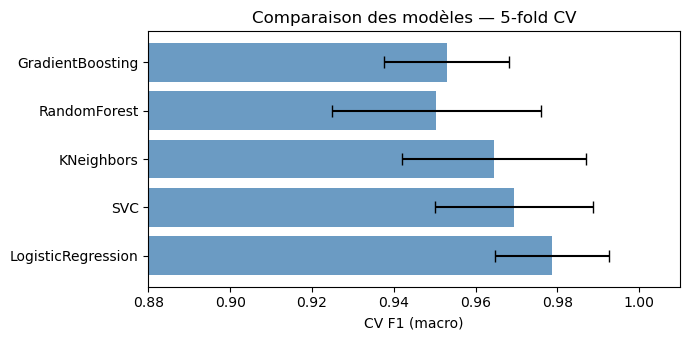

In [7]:
names = list(results.keys())
means = [results[n].mean() for n in names]
stds  = [results[n].std()  for n in names]

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.barh(names, means, xerr=stds, color="steelblue", alpha=0.8, capsize=4)
ax.set_xlabel("CV F1 (macro)")
ax.set_title("Comparaison des modèles — 5-fold CV")
ax.set_xlim(0.88, 1.01)
plt.tight_layout()
plt.show()

## Partie 5 — Recherche d'hyperparamètres

On applique `GridSearchCV` sur le meilleur modèle. Ici SVC, avec la notation `clf__param` pour cibler les paramètres du modèle dans le pipeline.

In [8]:
pipe_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC()),
])

param_grid = {
    "clf__C":      [0.1, 1, 10, 100],
    "clf__kernel": ["linear", "rbf"],
    "clf__gamma":  ["scale", "auto"],
}

grid = GridSearchCV(pipe_svc, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"Meilleur F1 (macro)  : {grid.best_score_:.3f}")

Meilleurs paramètres : {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Meilleur F1 (macro)  : 0.976


## Partie 6 — Évaluation finale

On évalue le meilleur modèle sur le **test set**, utilisé pour la première (et unique) fois.

In [9]:
best = grid.best_estimator_
y_pred = best.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))

              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



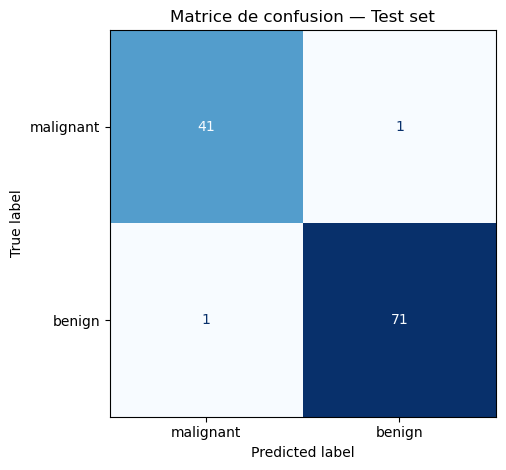

In [10]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=data.target_names)
disp.plot(colorbar=False, cmap="Blues")
plt.title("Matrice de confusion — Test set")
plt.tight_layout()
plt.show()